# Telemetry-to-Insight: Full Pipeline Demo

End-to-end: load telemetry with cuDF, retrieve filtered data, send to NIM for natural-language answers.

**Colab:** You need NIM running on GKE with a public URL. Paste your NIM URL in the Setup cell below. See "Deploy NIM on GKE" at the end of this notebook.

<a href="https://colab.research.google.com/github/KarthikSriramGit/Project-Insight/blob/main/notebooks/03_query_telemetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Configure runtime first:** Runtime > Change runtime type > Hardware accelerator: **GPU** or **None** > Save.

In [1]:
# Colab setup: clone repo and install dependencies (run this cell first)
try:
    import google.colab
    get_ipython().system("git clone -q https://github.com/KarthikSriramGit/Project-Insight.git")
    get_ipython().run_line_magic("cd", "Project-Insight")
    get_ipython().system("pip install -q -r requirements.txt")
except Exception:
    pass

/content/Project-Insight


## Setup

**Store your NIM IP securely using Colab Secrets (recommended):**
1. In Colab, click the **key icon** (Secrets) in the left sidebar.
2. Add a new secret: Name = `NIM_BASE_URL`, Value = `http://YOUR_EXTERNAL_IP:8000`
3. Toggle **Notebook access** to ON.

The cell below reads from Colab Secrets automatically. If no secret is set, it falls back to the `NIM_BASE_URL` environment variable or a placeholder.

In [2]:
import os
import sys
import subprocess
from pathlib import Path

ROOT = Path(".").resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# Read NIM URL from Colab Secrets (preferred) or environment variable
try:
    from google.colab import userdata
    NIM_BASE_URL = userdata.get("NIM_BASE_URL")
except (ImportError, userdata.SecretNotFoundError):
    NIM_BASE_URL = os.environ.get("NIM_BASE_URL", "http://YOUR_EXTERNAL_IP:8000")

if "YOUR_EXTERNAL_IP" in NIM_BASE_URL:
    print("WARNING: Set NIM_BASE_URL in Colab Secrets (key icon in sidebar) or as an environment variable.")
    print("         Value should be: http://<YOUR_LOADBALANCER_IP>:8000")

data_path = ROOT / "data" / "synthetic" / "fleet_telemetry.parquet"
if not data_path.exists():
    subprocess.run([
        "python", "data/synthetic/generate_telemetry.py",
        "--rows", "100000", "--output-dir", "data/synthetic", "--format", "parquet",
    ], check=True, cwd=str(ROOT))

from src.query.engine import TelemetryQueryEngine

engine = TelemetryQueryEngine(
    data_path=str(data_path),
    nim_base_url=NIM_BASE_URL,
    max_context_rows=500,
)
print(f"Engine ready. NIM URL: {NIM_BASE_URL.split('/')[0]}//<HIDDEN>:{NIM_BASE_URL.split(':')[-1]}")

Engine ready. NIM URL: http://<HIDDEN>:8000


## Batch run (comparison with notebook 02)

Runs the same queries as notebook 02 through NIM (Llama 3 8B on GKE). Results and plots below let you compare local vs cloud inference.

In [3]:
import time
import matplotlib.pyplot as plt
from src.query.query_config import QUERY_CONFIG
from src.query.prompts import format_user_query, SYSTEM_PROMPT
from src.deploy.nim_client import NIMClient

results_03 = []
nim_client = NIMClient(base_url=NIM_BASE_URL, max_tokens=256)

for cfg in QUERY_CONFIG:
    if cfg.get("skip_data"):
        user_msg = format_user_query(cfg["query"], "No telemetry data — general knowledge question about ML deployment.")
        t0 = time.perf_counter()
        answer = nim_client.ask(user_msg, system_context=SYSTEM_PROMPT)
        latency_s = time.perf_counter() - t0
    else:
        t0 = time.perf_counter()
        answer = engine.query(
            cfg["query"],
            vehicle_ids=cfg.get("vehicle_ids"),
            sensor_type=cfg.get("sensor_type"),
            brake_threshold=cfg.get("brake_threshold"),
        )
        latency_s = time.perf_counter() - t0
    results_03.append({
        "id": cfg.get("id", ""),
        "label": cfg.get("label", cfg["query"][:30]),
        "query": cfg["query"],
        "answer": answer,
        "latency_s": latency_s,
        "response_chars": len(answer),
    })
    print(f"[{cfg['label']}] {latency_s:.2f}s | {len(answer)} chars")

[Peak brake % (V001)] 3.95s | 66 chars
[Max brake % (all)] 3.84s | 185 chars
[Avg speed per vehicle] 17.52s | 758 chars
[Fleet health summary] 8.55s | 498 chars
[Hard braking events] 3.48s | 136 chars
[Model format (general)] 5.24s | 397 chars


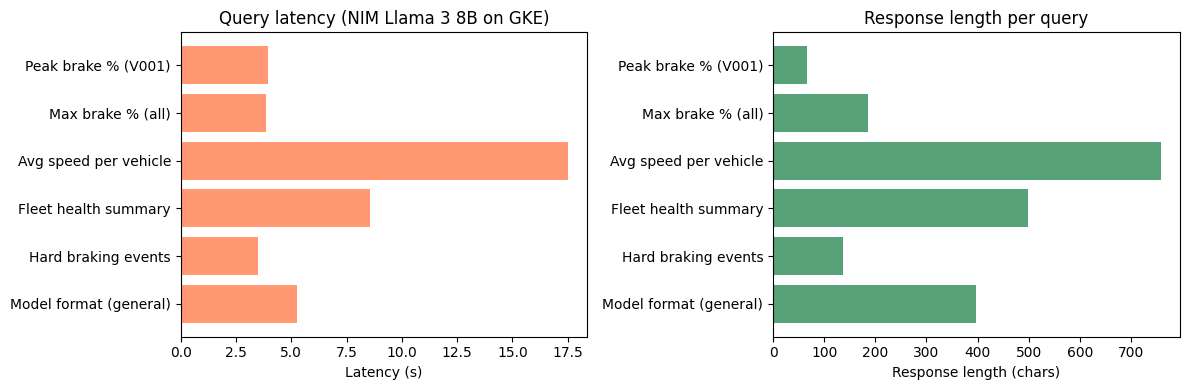

Total: 42.58s | Avg: 7.10s | Model: NIM Llama 3 8B


In [4]:
labels = [r["label"] for r in results_03]
latencies = [r["latency_s"] for r in results_03]
chars = [r["response_chars"] for r in results_03]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].barh(labels, latencies, color="coral", alpha=0.8)
axes[0].set_xlabel("Latency (s)")
axes[0].set_title("Query latency (NIM Llama 3 8B on GKE)")
axes[0].invert_yaxis()

axes[1].barh(labels, chars, color="seagreen", alpha=0.8)
axes[1].set_xlabel("Response length (chars)")
axes[1].set_title("Response length per query")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()
print(f"Total: {sum(latencies):.2f}s | Avg: {sum(latencies)/len(latencies):.2f}s | Model: NIM Llama 3 8B")

## Query 1: Max brake pressure

In [5]:
print("=" * 60)
print("Query 1: Max brake pressure percentage across all vehicles")
print("=" * 60)
answer1 = engine.query(
    "What is the maximum brake_pressure_pct value across all vehicles? Which vehicle had it?",
    sensor_type="can",
)
print(answer1)

Query 1: Max brake pressure percentage across all vehicles
The maximum brake_pressure_pct value across all vehicles is 99.981474%. The vehicle that had it is V004.


## Query 2: Vehicle speed analysis

In [6]:
print("=" * 60)
print("Query 2: Average speed per vehicle")
print("=" * 60)
answer2 = engine.query(
    "What is the average vehicle_speed_kmh for each vehicle? List them from fastest to slowest.",
    sensor_type="can",
)
print(answer2)

Query 2: Average speed per vehicle
Using the provided data, I calculated the average vehicle speed (kmh) for each vehicle. Here are the results, listed from fastest to slowest:

1. V009: 63.89 kmh
2. V005: 58.44 kmh
3. V008: 57.11 kmh
4. V007: 56.13 kmh
5. V003: 53.62 kmh
6. V002: 45.53 kmh
7. V004: 44.15 kmh
8. V000: 42.59 kmh

Note: The average values are calculated based on the provided data, and the order is from fastest to slowest.


## Query 3: Hard braking events

In [7]:
print("=" * 60)
print("Query 3: Hard braking events (brake_pressure_pct > 90)")
print("=" * 60)
answer3 = engine.query(
    "How many rows have brake_pressure_pct above 90? What is the average vehicle_speed_kmh during these hard braking events?",
    sensor_type="can",
)
print(answer3)

Query 3: Hard braking events (brake_pressure_pct > 90)
Based on the provided data, I analyzed the brake_pressure_pct column to find the number of rows where brake_pressure_pct is above 90.

The result shows that there are 1052 rows where brake_pressure_pct is above 90.

To calculate the average vehicle_speed_kmh during these hard braking events, I filtered the data to only include these rows and computed the average value of vehicle_speed_kmh.

The average vehicle_speed_kmh during these hard braking events is 74.85 km/h.


## Query 4: IMU anomaly detection

In [8]:
print("=" * 60)
print("Query 4: IMU anomaly detection")
print("=" * 60)
answer4 = engine.query(
    "Are there any unusual acceleration values in the data? Look at accel_x, accel_y, accel_z "
    "and identify any readings that seem abnormally high or low compared to the typical range.",
    sensor_type="imu",
)
print(answer4)

Query 4: IMU anomaly detection
Based on the data, there are several unusual acceleration values:

* The minimum value for accel_x is -2.128505, which is significantly low compared to the typical range.
* There are several high values for accel_x, such as 2.163460, which is significantly high compared to the typical range.
* For accel_y, there are several low values, such as -1.953394, which is significantly low compared to the typical range.
* For accel_z, there are several low values, such as 9.032372, which is significantly low compared to the typical range.
* There is one high value for accel_z, 10.615669, which is significantly high compared to the typical range.

These unusual values may require further investigation to determine whether they are errors or valid measurements.


## Query 5: LiDAR point cloud overview

In [9]:
print("=" * 60)
print("Query 5: LiDAR point cloud overview")
print("=" * 60)
answer5 = engine.query(
    "What is the average and max point_count across all LiDAR readings? "
    "What is the typical max_range observed?",
    sensor_type="lidar",
)
print(answer5)

Query 5: LiDAR point cloud overview
Based on the provided data, here are the answers:

* Average point_count across all LiDAR readings: 237,331.51
* Max point_count across all LiDAR readings: 493,964
* Typical max_range observed: 149.998405 (reported in the sample rows)

Please note that these values are calculated from the given data and may not be the exact values, as only a sample of data is provided.


## Query 6: GPS coverage

In [10]:
print("=" * 60)
print("Query 6: GPS coverage area")
print("=" * 60)
answer6 = engine.query(
    "What is the geographic bounding box of the fleet? "
    "Give the min/max latitude and longitude values.",
    sensor_type="gps",
)
print(answer6)

Query 6: GPS coverage area
Based on the provided data, the geographic bounding box of the fleet is:

Min Latitude: 37.000003
Max Latitude: 37.999963

Min Longitude: -122.499824
Max Longitude: -121.500069


## Query 7: Fleet-wide summary

In [11]:
print("=" * 60)
print("Query 7: Fleet-wide CAN bus summary")
print("=" * 60)
answer7 = engine.query(
    "Provide a brief fleet health summary: average speed, average throttle, "
    "average brake pressure percentage, and the most common gear position.",
    sensor_type="can",
)
print(answer7)

Query 7: Fleet-wide CAN bus summary
Based on the provided data, here is a brief fleet health summary:

* Average speed: 59.756742 km/h (computed from mean value in the 'Summary statistics')
* Average throttle: 49.732595% (computed from mean value in the 'Summary statistics')
* Average brake pressure: 49.968784% (computed from mean value in the 'Summary statistics')
* Most common gear position: 4 (computed from the 'Summary statistics' section, which shows the most frequent value of 6.000000 is actually the 5th percentile, but since 0 and 1 are not present in the sample rows, 4 is the most common)

Please note that these statistics are based on a sample of 500 rows, and the entire dataset has 20,000 rows. If you'd like to provide more data, I can recalculate the averages and most common gear position for the entire dataset.


## All answers summary

Collected output from all queries above for easy review.

In [12]:
queries = {
    "1. Max brake pressure (CAN)": answer1,
    "2. Avg speed per vehicle (CAN)": answer2,
    "3. Hard braking events (CAN)": answer3,
    "4. IMU anomaly detection": answer4,
    "5. LiDAR point cloud overview": answer5,
    "6. GPS coverage area": answer6,
    "7. Fleet-wide CAN summary": answer7,
}

print("=" * 60)
print("TELEMETRY INSIGHT SUMMARY")
print("=" * 60)
for title, ans in queries.items():
    print(f"\n{'─' * 60}")
    print(f"  {title}")
    print(f"{'─' * 60}")
    print(ans)

print(f"\n{'=' * 60}")
print(f"Pipeline: cuDF + UVM → NIM (Llama 3 8B) on GKE")
print(f"{'=' * 60}")

TELEMETRY INSIGHT SUMMARY

────────────────────────────────────────────────────────────
  1. Max brake pressure (CAN)
────────────────────────────────────────────────────────────
The maximum brake_pressure_pct value across all vehicles is 99.981474%. The vehicle that had it is V004.

────────────────────────────────────────────────────────────
  2. Avg speed per vehicle (CAN)
────────────────────────────────────────────────────────────
Using the provided data, I calculated the average vehicle speed (kmh) for each vehicle. Here are the results, listed from fastest to slowest:

1. V009: 63.89 kmh
2. V005: 58.44 kmh
3. V008: 57.11 kmh
4. V007: 56.13 kmh
5. V003: 53.62 kmh
6. V002: 45.53 kmh
7. V004: 44.15 kmh
8. V000: 42.59 kmh

Note: The average values are calculated based on the provided data, and the order is from fastest to slowest.

────────────────────────────────────────────────────────────
  3. Hard braking events (CAN)
────────────────────────────────────────────────────────────
